# COCO Eye Tracking and Segmentation

Here, we’ll explore eye-tracking and image segmentation using the COCO dataset.

---

In [1]:
import importlib
import subprocess
import sys

# Function to check and install a library
def install_if_missing(library_name):
    try:
        importlib.import_module(library_name)
        print(f"{library_name} is already installed.")
    except ImportError:
        print(f"{library_name} is not installed. Installing...")
        subprocess.check_call([sys.executable, "-m", "pip", "install", library_name])

# Check and install each library
libraries = {
    "pandas": "pandas",
    "numpy": "numpy",
    "cv2": "opencv-python",
    "matplotlib": "matplotlib",
    "requests": "requests",
    "PIL": "pillow",
    'shapely': 'shapely'
}

for module, package in libraries.items():
    install_if_missing(package)

pandas is already installed.
numpy is already installed.
opencv-python is not installed. Installing...
matplotlib is already installed.
requests is already installed.
pillow is not installed. Installing...
shapely is already installed.


In [2]:
# Import libraries
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import requests
import json
import random
import zipfile
import os
import io

from pprint import pprint
from io import BytesIO
from PIL import Image
from shapely.geometry import Point, Polygon

---

## The basics

### What is COCO?
COCO (short for *Common Objects in Context*) is a popular dataset in computer vision. It’s massive and is often used for tasks like **object detection**, **image segmentation**, and **image captioning**. Think of it as a treasure trove of labeled images that help train and evaluate AI models to better understand the visual world.

### Exploring COCO Data in Python
We are mostly interested in the `instances_val2017.json` file, which contains the annotations for the validation set. It’s a JSON file that contains information about the images, objects, and their locations in the images.

### What is Segmentation?
**Segmentation** is the process of dividing an image into smaller parts, called segments. Each segment represents a meaningful region of the image, like a car, a tree, or the sky. Segmentation helps machines understand “where” objects are in an image and how they are shaped. This is different from just knowing “what” the objects are (classification) or their approximate locations (detection).

#### Saving Segmentation Data  
There are two main ways segmentation data can be stored:

1. **Pixel-wise Segmentation**  
This method creates a matrix (or 2D array) that matches the size of the image. Each pixel in the matrix is assigned a class number that represents what object it belongs to. For example:
    0 = background
    1 = car
    2 = tree

2. **Polygon-wise Segmentation**  
Instead of storing pixel values, this method saves the coordinates of the points that form the boundaries of each object (polygons). For example:
[x1, y1, x2, y2, ...].

This is how the COCO dataset stores segmentation information. It’s compact and efficient, especially for large datasets.

### Eye tracking
Eye tracking is the process of measuring either the point of gaze (where one is looking) or the motion of an eye relative to the head. An eye tracker is a device for measuring eye positions and eye movement. Eye trackers are used in research on the visual system, in psychology, in cognitive linguistics, and in product design.

#### How to save them?  
We can save them as a three columned table. The first column is the x-coordinate, the second column is the y-coordinate, and the third column is the duration that the user has looked at that point (or it can be the timestamp that the fixation started).

---

## General Tasks

In [3]:
# URL of the zip file
zip_url = "http://images.cocodataset.org/annotations/annotations_trainval2017.zip"

# Download the zip file into memory
response = requests.get(zip_url)
response.raise_for_status()  # Raise an error for bad status codes

# Open the zip file
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    # List all files in the zip archive
    file_names = z.namelist()
    print("Files in the archive:", file_names)  # Optional: see all files in the zip
    
    # Extract and read the specific JSON file
    with z.open("annotations/instances_train2017.json") as json_file:
        coco_data = json.load(json_file)

# Now `coco_data` contains the JSON content
print("JSON keys:", coco_data.keys())  # Optional: Inspect the structure


Files in the archive: ['annotations/instances_train2017.json', 'annotations/instances_val2017.json', 'annotations/captions_train2017.json', 'annotations/captions_val2017.json', 'annotations/person_keypoints_train2017.json', 'annotations/person_keypoints_val2017.json']
JSON keys: dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])


In [4]:
# Extract the relevant columns from coco_data['images']
images_df = pd.DataFrame([{
    'file_name': image['file_name'],
    'height': image['height'],
    'width': image['width'],
    'image_id': image['id'],
    'address': image['coco_url']
} for image in coco_data['images']])

images_df['image_area'] = images_df['height']*images_df['width']

In [5]:
annotations_df = pd.DataFrame(coco_data['annotations'])
annotations_df = annotations_df.drop(columns=['iscrowd'])
annotations_df = annotations_df.rename(columns={'area': 'segment_area','bbox': 'segment_bbox','id': 'segment_id'})

In [6]:
categories_df = pd.DataFrame(coco_data['categories'])
categories_df = categories_df.rename(columns={'id': 'category_id','name': 'category_name'})

### 1. Mask on the image  
Write a function that recives an image and a segmentation mask and draws the mask on the image

#### Steps to Create the Function
**1. Fetch the Image:**

Use the `coco_url` in the `images_df` dataframe (column `address`) to download the image. We can use libraries like `requests` or `urllib` for this.

**2. Parse the Segmentation Mask:**

The `segmentation` mask in the `annotations_df` dataframe (column `segmentation`) contains a list of coordinates for drawing the polygon.

**3. Draw the Mask:**

Use a library like `OpenCV` or `Pillow` to overlay the segmentation mask on the image.

**4. Display or Save the Result:**

Show the image with the mask using `matplotlib` or save it to a file.


In [7]:
def draw_mask_on_image(image: np.ndarray, mask: np.ndarray) -> np.ndarray:
    if mask.ndim == 1:
        mask = mask.reshape(-1, 2)
    if mask.shape[1] != 2:
        raise ValueError("The mask should be a 2D array with 2 columns")

    # Ensure the mask is integer type for drawing
    mask = mask.astype(np.int32)

    assert mask.ndim == 2, "The mask should be a 2D array"
    
    # Create a copy of the image to avoid modifying the original
    image = image.copy()

    # Create a mask image (all zeros initially)
    mask_image = np.zeros_like(image, dtype=np.uint8)

    # Fill the mask with light blue color (BGR format)
    light_blue = (173, 216, 230)  # Light blue color in BGR
    cv2.fillPoly(mask_image, [mask], color=light_blue)

    # Increase the intensity of the inside area
    image = cv2.addWeighted(image, 1, mask_image, 0.5, 0)  # Adjusted intensity

    # Draw the contour of the mask (edges with high intensity, red color)
    cv2.polylines(image, [mask], isClosed=True, color=(0, 0, 255), thickness=2)  # Red edges

    return image

In [8]:
# Function to process the image and annotation
def process_image_and_mask(coco_data, image_info):
    image_id = image_info['id']
    image_url = image_info['coco_url']

    # Download the image
    response = requests.get(image_url)
    image = np.array(Image.open(BytesIO(response.content)).convert("RGB"))

    # Find annotations corresponding to the selected image
    annotations = [ann for ann in coco_data['annotations'] if ann['image_id'] == image_id]

    if annotations:
        # Use the first annotation for simplicity
        annotation = annotations[0]
        segmentation = annotation['segmentation'][0]  # Assume only one segment per annotation
        category_id = annotation['category_id']

        # Find the category name from category_id
        category_info = next(cat for cat in coco_data['categories'] if cat['id'] == category_id)
        category_name = category_info['name']

        # Convert segmentation to a numpy array
        segmentation_np = np.array(segmentation)

        # Draw the mask on the image
        masked_image = draw_mask_on_image(image, segmentation_np)

        # Display the original and masked images with the category name
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        
        # Original Image
        axes[0].imshow(image)
        axes[0].set_title("Original Image")
        axes[0].axis('off')
        
        # Masked Image
        axes[1].imshow(masked_image)
        axes[1].set_title(f"Image with Segmentation Mask\nCategory: {category_name}")
        axes[1].axis('off')
        
        plt.show()
    else:
        print(f"No annotations found for the image with ID {image_id}.")

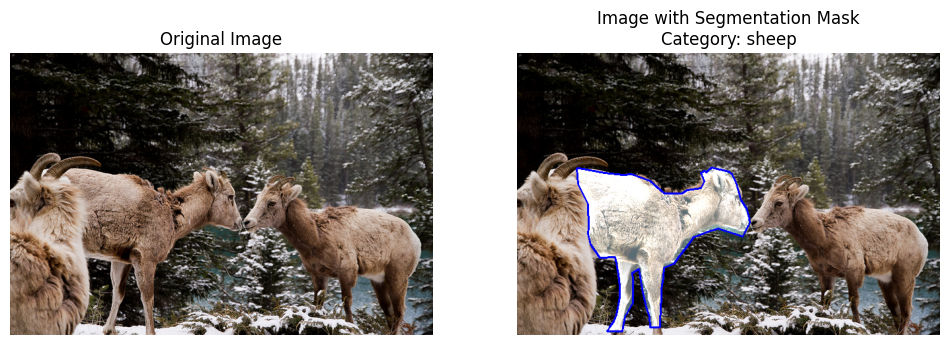

In [9]:
# Select a random image
image_info = random.choice(coco_data['images'])

# Call the function, passing the coco_data and the selected image
process_image_and_mask(coco_data, image_info)

In [10]:
# Function to process the image and annotation
def process_image_and_mask_mseg(coco_data, image_info):
    image_id = image_info['id']
    image_url = image_info['coco_url']
      
    # Download the image
    response = requests.get(image_url)
    image = np.array(Image.open(BytesIO(response.content)).convert("RGB"))
      
    # Find annotations corresponding to the selected image
    annotations = [ann for ann in coco_data['annotations'] if ann['image_id'] == image_id]
      
    if annotations:
        # Use the first annotation for simplicity
        masked_image = image.copy()
        no_seg = 0
        for annotation in annotations:
            if isinstance(annotation['segmentation'], list):
                segmentation = annotation['segmentation'][0]  # Assume only one segment per annotation
                
                # Convert segmentation to a numpy array
                segmentation_np = np.array(segmentation)
                no_seg += 1

                # Draw the mask on the image
                masked_image = draw_mask_on_image(masked_image, segmentation_np)

        # Display the original and masked images with the category name
        fig, axes = plt.subplots(1, 2, figsize=(12, 6))
        
        # Original Image
        axes[0].imshow(image)
        axes[0].set_title("Original Image")
        axes[0].axis('off')
        
        # Masked Image
        axes[1].imshow(masked_image)
        axes[1].set_title(f"Image with Segmentation Mask\nNo. of Segments: {no_seg}")
        axes[1].axis('off')
        
        plt.show()
    else:
        print(f"No annotations found for the image with ID {image_id}.")

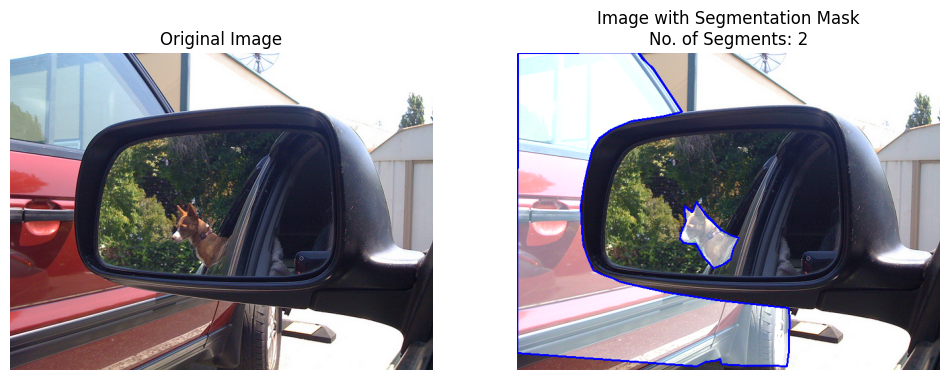

In [11]:
# Select a random image outside the function
image_info = random.choice(coco_data['images'])

# Call the function, passing the coco_data and the selected image
process_image_and_mask_mseg(coco_data, image_info)

---

### 2. Gaze points on the image  
Write a function that recives an image and gaze points and draws the gaze points on the image.

>Note: the radius of the gaze point should be proportional to the duration of the fixation.

In [12]:
def load_fixation_data_online(subject: int, zip_url: str) -> pd.DataFrame:
    # Step 1: Download the zip file into memory
    response = requests.get(zip_url)
    response.raise_for_status()  # Ensure the request was successful

    fixation_data = []

    # Step 2: Open the zip file
    with zipfile.ZipFile(io.BytesIO(response.content)) as z:
        # Step 3: Find files ending with '_split1.json'
        split1_files = [f for f in z.namelist() if f.endswith('_split1.json')]
        
        # Step 4: Iterate through these files and read the JSON content
        for json_file in split1_files:
            with z.open(json_file) as f:
                data = json.load(f)
                
                # Step 5: Filter entries for the specified subject
                for entry in data:
                    if entry['subject'] == subject:
                        # Add the json_file column and append the entry
                        entry['json_file'] = json_file
                        fixation_data.append(entry)
    
    # Step 6: Create a DataFrame from the fixation data
    df = pd.DataFrame(fixation_data)
    
    return df

In [13]:
# Load the fixation data for subject 1
# URL of the zip file
fixations_zip_url = "http://vision.cs.stonybrook.edu/~cvlab_download/COCOSearch18-fixations-TP.zip"
# Load fixation data for subject 1
subject_df = load_fixation_data_online(1, fixations_zip_url)
subject_df = subject_df.drop(columns=['condition','correct','RT','split','json_file'])
subject_df = subject_df.rename(columns={'name': 'image_name', 'task': 'category_name', 'length': 'no_gaze_points'})

In [14]:
subject_df_merged = pd.merge(subject_df, images_df, left_on=['image_name'], right_on=['file_name'], how='left')
subject_df_merged = subject_df_merged.drop(columns=['file_name'])

In [15]:
def draw_gaze_points_and_bbox(
    image: np.ndarray, gaze_points: pd.DataFrame, image_title: str, category: str
) -> None:
    """
    Draw gaze points on the image, connect them consecutively with lines, and separately draw bounding boxes.
    Print the image name, category, gaze points, and bounding boxes after the image.
    
    :param image: The image on which to draw.
    :param gaze_points: A DataFrame with columns 'X', 'Y', 'T', and 'bbox'.
    :param image_title: The title (name) of the image.
    :param category: The category or task of the image.
    
    :return: None
    """
    # Create a matplotlib axis to draw on the image
    image_copy = image.copy()
    fig, ax = plt.subplots()
    ax.imshow(image_copy)

    # Draw gaze points and connect them with lines
    for idx, row in gaze_points.iterrows():
        x_values = row['X']
        y_values = row['Y']
        duration_values = row['T']

        if len(x_values) == len(y_values) == len(duration_values):
            # Draw lines connecting consecutive gaze points
            if len(x_values) > 1:
                ax.plot(x_values, y_values, color='green', linewidth=1.5, alpha=0.5)

            # Draw gaze points as circles
            for i, (x, y, duration) in enumerate(zip(x_values, y_values, duration_values), start=1):
                radius = duration / 10  # Adjust for better visibility
                circle = plt.Circle((x, y), radius, facecolor='yellow', edgecolor='red', fill=True, alpha=0.6)
                ax.add_patch(circle)
                ax.text(x, y, str(i), color='black', fontsize=8, ha='center', va='center')
        else:
            print(f"Mismatch in gaze point lengths at index {idx}.")

    # Draw bounding boxes
    for idx, row in gaze_points.iterrows():
        bbox = row['bbox']
        if isinstance(bbox, list) and len(bbox) == 4:
            bbox_x, bbox_y, bbox_w, bbox_h = bbox
            rect = plt.Rectangle(
                (bbox_x, bbox_y), bbox_w, bbox_h,
                edgecolor='red', facecolor='none', linewidth=2, alpha=0.7
            )
            ax.add_patch(rect)
        else:
            print(f"Invalid bbox format at index {idx}: {bbox}")

    # Show axes for better understanding
    ax.axis('on')

    # Display the image
    plt.show()

    # Print details after the image
    print(f"Image Name: {image_title}")
    print(f"Task: {category}")
    print("Gaze Points (X, Y, Duration):")
    for idx, row in gaze_points.iterrows():
        x_values = row['X']
        y_values = row['Y']
        duration_values = row['T']
        for i, (x, y, duration) in enumerate(zip(x_values, y_values, duration_values), start=1):
            print(f"  {i}. X: {x}, Y: {y}, Duration: {duration}")
    print("\nBounding Boxes (x, y, w, h):")
    for idx, row in gaze_points.iterrows():
        bbox = row['bbox']
        if isinstance(bbox, list) and len(bbox) == 4:
            print(f"  BBox: {bbox}")
        else:
            print(f"Invalid bbox format: {bbox}")

In [16]:
def adjust_coordinates_and_bbox(row, dif_ux, dif_uy, scale_x, scale_y):
    """Adjust both gaze point coordinates and bounding box coordinates."""
    adjusted_x, adjusted_y = [], []
    adjusted_bbox = []

    # Adjust gaze points
    for x, y in zip(row['X'], row['Y']):
        adj_x = int((x - dif_ux) * scale_x)
        adj_y = int((y - dif_uy) * scale_y)
        adjusted_x.append(adj_x)
        adjusted_y.append(adj_y)

    # Adjust bounding boxes
    if isinstance(row['bbox'], list) and len(row['bbox']) == 4:
        bbox_x, bbox_y, bbox_w, bbox_h = row['bbox']
        adj_bbox_x = int((bbox_x - dif_ux) * scale_x)
        adj_bbox_y = int((bbox_y - dif_uy) * scale_y)
        adj_bbox_w = int(bbox_w * scale_x)
        adj_bbox_h = int(bbox_h * scale_y)
        adjusted_bbox = [adj_bbox_x, adj_bbox_y, adj_bbox_w, adj_bbox_h]
    else:
        adjusted_bbox = row['bbox']  # Preserve original if invalid

    return {'X': adjusted_x, 'Y': adjusted_y, 'T': row['T'], 'bbox': adjusted_bbox}

def calculate_scaling_factors(actual_width, actual_height, display_width, display_height):
    """Calculate scaling factors and adjustment deltas."""
    target_ratio = display_width / float(display_height)
    actual_ratio = actual_width / float(actual_height)

    delta_w, delta_h = 0, 0
    if actual_ratio > target_ratio:
        new_width = display_width
        new_height = int(new_width / actual_ratio)
        delta_h = display_height - new_height
    else:
        new_height = display_height
        new_width = int(new_height * actual_ratio)
        delta_w = display_width - new_width

    dif_ux = delta_w // 2
    dif_uy = delta_h // 2
    scale_x = display_width / float(new_width)
    scale_y = display_height / float(new_height)

    return dif_ux, dif_uy, scale_x, scale_y

In [17]:
# Function to process the image and annotation
def mask_and_gaze(image,annotations):
     
    if annotations:
        masked_image = image.copy()
        no_seg = 0
        for annotation in annotations:
            if isinstance(annotation['segmentation'], list):
                segmentation = annotation['segmentation'][0]  # Assume only one segment per annotation
                
                # Convert segmentation to a numpy array
                segmentation_np = np.array(segmentation)
                no_seg += 1

                # Draw the mask on the image
                masked_image = draw_mask_on_image(masked_image, segmentation_np)
    else:
        print("No annotations found for the image")
    return masked_image

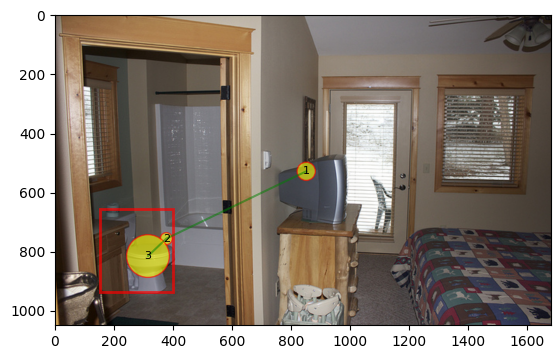

Image Name: 000000072018.jpg
Task: toilet
Gaze Points (X, Y, Duration):
  1. X: 851, Y: 528, Duration: 309
  2. X: 377, Y: 756, Duration: 203
  3. X: 315, Y: 815, Duration: 724

Bounding Boxes (x, y, w, h):
  BBox: [152, 656, 247, 282]


In [18]:
# Example usage
random_row = subject_df_merged.sample(n=1).iloc[0]
random_image_path = random_row['address']
random_image_title = random_row['image_name']  # Image title
category = random_row['category_name']  # Category (task)

# Define the display dimensions (source coordinate system)
display_width, display_height = 1680, 1050

# Load the image from the URL
response = requests.get(random_image_path)
downloaded_image = Image.open(BytesIO(response.content)).convert("RGB")

# Extract the actual dimensions of the downloaded image
actual_width, actual_height = downloaded_image.size

# Resize the image to the display dimensions for visualization
resized_image = downloaded_image.resize((display_width, display_height), Image.BICUBIC)
image = np.array(resized_image)  # Convert to numpy array for the drawing function

# Calculate scaling factors and deltas
dif_ux, dif_uy, scale_x, scale_y = calculate_scaling_factors(actual_width, actual_height, display_width, display_height)

# Get the gaze points for this row (ensure it's a DataFrame)
gaze_points = subject_df_merged[subject_df_merged['image_name'] == random_image_title]

# Apply adjustments to the entire DataFrame
gaze_points_adj = []
for _, row in gaze_points.iterrows():
    gaze_points_adj.append(adjust_coordinates_and_bbox(row, dif_ux, dif_uy, scale_x, scale_y))

# Convert adjusted data to a DataFrame
gaze_points_adj_df = pd.DataFrame(gaze_points_adj)

# Call the function to draw gaze points and bounding boxes on the image
draw_gaze_points_and_bbox(image, gaze_points_adj_df, random_image_title, category)

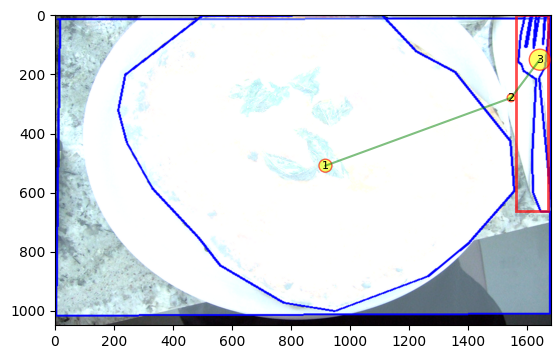

Image Name: 000000480082.jpg
Task: fork
Gaze Points (X, Y, Duration):
  1. X: 916, Y: 509, Duration: 220
  2. X: 1545, Y: 279, Duration: 134
  3. X: 1642, Y: 150, Duration: 356

Bounding Boxes (x, y, w, h):
  BBox: [1560, 0, 109, 662]


In [65]:
# Example usage
random_row = subject_df_merged[subject_df_merged['image_name'] == "000000480082.jpg"].iloc[0]
random_image_path = random_row['address']
random_image_title = random_row['image_name']
random_image_id = random_row['image_id']
category = random_row['category_name']  # Category (task)

# Define the display dimensions (source coordinate system)
display_width, display_height = 1680, 1050

# Load the image from the URL
response = requests.get(random_image_path)
downloaded_image = Image.open(BytesIO(response.content)).convert("RGB")

# Extract the actual dimensions of the downloaded image
actual_width, actual_height = downloaded_image.size

# Find annotations corresponding to the selected image
annotations = [ann for ann in coco_data['annotations'] if ann['image_id'] == random_image_id]

masked_image = mask_and_gaze(np.array(downloaded_image), annotations)

# Resize the image to the original dimensions
resized_image = cv2.resize(masked_image, (display_width, display_height), interpolation=cv2.INTER_CUBIC)

# Calculate scaling factors and deltas
dif_ux, dif_uy, scale_x, scale_y = calculate_scaling_factors(actual_width, actual_height, display_width, display_height)

# Get the gaze points for this row (ensure it's a DataFrame)
gaze_points = subject_df_merged[subject_df_merged['image_name'] == random_image_title]

# Apply adjustments to the entire DataFrame
gaze_points_adj = []
for _, row in gaze_points.iterrows():
    gaze_points_adj.append(adjust_coordinates_and_bbox(row, dif_ux, dif_uy, scale_x, scale_y))

# Convert adjusted data to a DataFrame
gaze_points_adj_df = pd.DataFrame(gaze_points_adj)

# Call the function to draw gaze points and bounding boxes on the image
draw_gaze_points_and_bbox(resized_image, gaze_points_adj_df, random_image_title, category)

---

### 3. Calculate average area
For each class in the COCO dataset, calculate the average area of the objects.

In [20]:
annotations_df_merged = pd.merge(annotations_df, images_df, left_on=['image_id'], right_on=['image_id'], how='left')
annotations_df_merged = pd.merge(annotations_df_merged, categories_df, left_on=['category_id'], right_on=['category_id'], how='left')
annotations_df_merged['nor_seg_area'] = annotations_df_merged['segment_area'] *100/ (annotations_df_merged['image_area'])

In [ ]:
# Group annotations_df by 'category_id'
area_df = annotations_df_merged.groupby('supercategory').agg(
    no_object=('supercategory', 'size'),               # Count the number of objects for each category_id
    avg_area=('segment_area', 'mean'),                      # Sum of the areas for each category_id
    avg_normalized_area=('nor_seg_area', 'mean')                    # Average area for each category_id
)

# Sort the summary dataframe by 'no_object' in descending order
area_df = area_df.sort_values(by='avg_normalized_area', ascending=False)

# Display the summary dataframe
print(area_df)

               no_object      avg_area  avg_normalized_area
supercategory                                              
furniture          76985  26113.620209             9.288124
appliance          13479  24060.596500             8.754706
animal             62566  17320.920152             6.288056
food               63512  14384.791941             5.030661
vehicle            96212  13409.212443             4.817807
electronic         28029  12131.449256             4.536337
person            262465  11177.115991             4.060023
outdoor            27855   8169.834105             2.973828
indoor             46088   6476.335824             2.393242
accessory          45193   6567.678243             2.366073
kitchen            86677   5481.665254             1.922043
sports             50940   2915.483291             1.073563


## Advanced Tasks

### 1. Find the most attractive class in the dataset
For each class in the COCO dataset, calculate the average duration that the users have looked at the objects of that class. You need to loop over all the images and all the gaze points and find the most attractive class.

The main barrier here is to know if a gaze point is inside an object or not.

In [22]:
seg_gaze_df =  pd.merge(subject_df, annotations_df_merged, left_on=['image_name', 'category_name'], right_on=['file_name', 'category_name'], how='left')

In [50]:
# Function to calculate scaling factors for gaze points
def calculate_scaling_factors(actual_width, actual_height, display_width=1680, display_height=1050):
    target_ratio = display_width / float(display_height)
    actual_ratio = actual_width / float(actual_height)
    
    delta_w, delta_h = 0, 0
    if actual_ratio > target_ratio:
        new_width = display_width
        new_height = int(new_width / actual_ratio)
        delta_h = display_height - new_height
    else:
        new_height = display_height
        new_width = int(new_height * actual_ratio)
        delta_w = display_width - new_width
    
    dif_ux = delta_w // 2
    dif_uy = delta_h // 2
    scale_x = display_width / float(new_width)
    scale_y = display_height / float(new_height)
    
    return dif_ux, dif_uy, scale_x, scale_y

# Function to adjust gaze points and bounding boxes
def adjust_gaze_and_bbox(row, dif_ux, dif_uy, scale_x, scale_y):
    adjusted_x, adjusted_y, adjusted_bbox = [], [], []

    # Adjust gaze points
    for x, y in zip(row['X'], row['Y']):
        adj_x = int((x - dif_ux) * scale_x)
        adj_y = int((y - dif_uy) * scale_y)
        adjusted_x.append(adj_x)
        adjusted_y.append(adj_y)

    # Adjust bounding box if valid
    if isinstance(row['bbox'], list) and len(row['bbox']) == 4:
        bbox_x, bbox_y, bbox_w, bbox_h = row['bbox']
        adj_bbox_x = int((bbox_x - dif_ux) * scale_x)
        adj_bbox_y = int((bbox_y - dif_uy) * scale_y)
        adj_bbox_w = int(bbox_w * scale_x)
        adj_bbox_h = int(bbox_h * scale_y)
        adjusted_bbox = [adj_bbox_x, adj_bbox_y, adj_bbox_w, adj_bbox_h]
    else:
        adjusted_bbox = row['bbox']  # Preserve original if invalid

    return adjusted_x, adjusted_y, adjusted_bbox

# Function to parse and resize segmentation
def parse_and_resize_segmentation(segmentation, actual_width, actual_height, display_width=1680, display_height=1050):
    if isinstance(segmentation, list) and segmentation:
        coords = np.array(segmentation[0]).reshape(-1, 2)
        scale_x = display_width / float(actual_width)
        scale_y = display_height / float(actual_height)

        resized_coords = [
            [round(float(x * scale_x), 2), round(float(y * scale_y), 2)]  # Ensure it's a list of floats rounded to 2 decimal places
            for x, y in coords
        ]
        
        # Flatten the list of coordinates to match the format you expect
        flattened_resized_coords = [coord for pair in resized_coords for coord in pair]

        # Convert the resized coordinates back into the input format (nested list)
        return [flattened_resized_coords]
    return None

# Function to process gaze points and segmentation for each row in the DataFrame
def check_gaze_points_inside(seg_gaze_df, display_width=1680, display_height=1050):
    inside_flags = []  
    summed_durations = []  

    filtered_df = seg_gaze_df.dropna(subset=['width', 'height']).copy()  

    adjusted_x_list = []
    adjusted_y_list = []
    adjusted_bbox_list = []
    resized_segmentation_list = []

    for _, row in filtered_df.iterrows():
        actual_width, actual_height = row['width'], row['height']
        
        if actual_width == 0 or actual_height == 0:
            raise ValueError(f"Invalid image dimensions for row {row.name}: Width and height must be non-zero.")
        
        dif_ux, dif_uy, scale_x_gaze, scale_y_gaze = calculate_scaling_factors(actual_width, actual_height, display_width, display_height)
        
        adjusted_x, adjusted_y, adjusted_bbox = adjust_gaze_and_bbox(row, dif_ux, dif_uy, scale_x_gaze, scale_y_gaze)
        
        resized_segmentation = parse_and_resize_segmentation(row['segmentation'], actual_width, actual_height, display_width, display_height)
        
        inside_list = []
        total_duration = 0
        if resized_segmentation:
            # Create the Polygon for the resized segmentation area
            segmentation_polygon = Polygon(np.array(resized_segmentation[0]).reshape(-1, 2))

            for x, y, duration in zip(adjusted_x, adjusted_y, row['T']):
                point = Point(x, y)
                # Check if the gaze point is inside the segmentation or inside the bounding box
                is_inside_segmentation = segmentation_polygon.contains(point)
                is_inside_bbox = (
                    adjusted_bbox[0] <= x <= adjusted_bbox[0] + adjusted_bbox[2] and
                    adjusted_bbox[1] <= y <= adjusted_bbox[1] + adjusted_bbox[3]
                )
                # A gaze point is considered inside if it is inside either the segmentation or the bounding box
                is_inside = is_inside_segmentation #or is_inside_bbox
                inside_list.append(is_inside)
                if is_inside:
                    total_duration += duration
        else:
            inside_list = [False] * len(adjusted_x)  # If no segmentation, assume all points are outside
        
        inside_flags.append(inside_list)
        summed_durations.append(total_duration)

        adjusted_x_list.append(adjusted_x)
        adjusted_y_list.append(adjusted_y)
        adjusted_bbox_list.append(adjusted_bbox)
        resized_segmentation_list.append(resized_segmentation)

    # Add the new columns to the DataFrame
    filtered_df['inside_segmentation'] = [json.dumps(inside_list) for inside_list in inside_flags]
    filtered_df['summed_dur'] = summed_durations

    filtered_df['adjusted_X'] = adjusted_x_list
    filtered_df['adjusted_Y'] = adjusted_y_list
    filtered_df['adjusted_bbox'] = adjusted_bbox_list
    filtered_df['resized_segmentation'] = resized_segmentation_list

    # Rearrange columns to place adjusted columns next to the original ones after the first column
    cols = list(filtered_df.columns)
    
    # Define the column groups
    original_columns = ['X', 'Y', 'bbox', 'segmentation']
    adjusted_columns = ['adjusted_X', 'adjusted_Y', 'adjusted_bbox', 'resized_segmentation']
    
    # Create the new column order
    new_column_order = [cols[0]]  # Keep the first column in place
    
    for original, adjusted in zip(original_columns, adjusted_columns):
        new_column_order.append(original)
        new_column_order.append(adjusted)

    # Add other columns to the new column order
    for col in cols:
        if col not in original_columns + adjusted_columns + [cols[0]]:
            new_column_order.append(col)

    # Return the DataFrame with columns reordered
    return filtered_df[new_column_order]

In [24]:
# Apply the function
seg_gaze_df_processed = check_gaze_points_inside(seg_gaze_df)
seg_gaze_df_processed['normalized_dur'] = seg_gaze_df_processed['summed_dur']/seg_gaze_df_processed['nor_seg_area']

In [25]:
attractive_cat_df = seg_gaze_df_processed.groupby('category_name').agg(
    no_gaze=('category_name', 'size'),               # Count the number of objects for each category_id
    normalized_dur=('normalized_dur', 'mean')                      # Sum of the areas for each category_id
)

attractive_cat_df = attractive_cat_df.sort_values(by='normalized_dur', ascending=False)
print(attractive_cat_df)

               no_gaze  normalized_dur
category_name                         
knife              113      622.292367
fork               181      584.721628
potted plant       124      555.623169
clock               95      433.091021
car                 81      411.095602
bottle             130      383.693464
mouse               86      375.555169
laptop              95      372.278272
bowl               109      313.205360
tv                 224      284.356632
cup                220      282.488069
keyboard           144      281.310598
sink               218      274.476018
chair              196      270.647883
microwave          124      265.161953
oven                80      247.426399
stop sign           99      229.491105
toilet             123      166.239040


In [26]:
attractive_supcat_df = seg_gaze_df_processed.groupby('supercategory').agg(
    no_gaze=('supercategory', 'size'),               # Count the number of objects for each category_id
    normalized_dur=('normalized_dur', 'mean')                      # Sum of the areas for each category_id
)

attractive_supcat_df = attractive_supcat_df.sort_values(by='normalized_dur', ascending=False)
print(attractive_supcat_df)

               no_gaze  normalized_dur
supercategory                         
indoor              95      433.091021
kitchen            753      428.048555
vehicle             81      411.095602
furniture          443      321.425869
electronic         549      313.057909
appliance          422      266.611294
outdoor             99      229.491105


In [29]:
# Ensure 'inside_segment' is converted from JSON string to a list if necessary
seg_gaze_df_processed['inside_segmentation'] = seg_gaze_df_processed['inside_segmentation'].apply(json.loads)

# Create the 'no_gaze_inside' column by counting True values in each entry of 'inside_segment'
seg_gaze_df_processed['no_gaze_inside'] = seg_gaze_df_processed['inside_segmentation'].apply(lambda x: sum(x))

# Optionally rearrange columns to place 'no_gaze_inside' next to 'inside_segment'
cols = seg_gaze_df_processed.columns.tolist()
inside_segment_index = cols.index('inside_segmentation')
cols.insert(inside_segment_index + 1, cols.pop(cols.index('no_gaze_inside')))
seg_gaze_df_processed = seg_gaze_df_processed[cols]


In [32]:
# Ensure a copy of the DataFrame to avoid SettingWithCopyWarning
seg_gaze_df_processed = seg_gaze_df_processed.copy()

# Create the 'no_gaze_inside_perc' column as the percentage
seg_gaze_df_processed['gaze_inside_perc'] = (
    seg_gaze_df_processed['no_gaze_inside'] * 100 / seg_gaze_df_processed['no_gaze_points']
).round(2)

# Rearrange columns to place 'no_gaze_inside_perc' next to 'no_gaze_inside'
cols = seg_gaze_df_processed.columns.tolist()
no_gaze_inside_index = cols.index('no_gaze_inside')
cols.insert(no_gaze_inside_index + 1, cols.pop(cols.index('gaze_inside_perc')))
seg_gaze_df_processed = seg_gaze_df_processed[cols]


In [35]:
avg_gaze_inside_df = seg_gaze_df_processed.groupby('category_name').agg(
    avg_gaze_inside_perc=('gaze_inside_perc', 'mean')                      # Sum of the areas for each category_id
)

# Round the result to 1 decimal point
avg_gaze_inside_df = avg_gaze_inside_df.round(1)

avg_gaze_inside_df = avg_gaze_inside_df.sort_values(by='avg_gaze_inside_perc', ascending=False)
print(avg_gaze_inside_df)

               avg_gaze_inside_perc
category_name                      
tv                             58.2
laptop                         53.4
stop sign                      53.4
clock                          53.2
keyboard                       51.6
knife                          51.1
oven                           50.2
sink                           49.1
fork                           48.8
microwave                      48.1
mouse                          47.7
cup                            47.0
potted plant                   46.4
car                            43.3
bowl                           42.4
chair                          42.0
bottle                         41.8
toilet                         37.9


### 2. Does Object Size Drive First Glance Attention?
Analyze the correlation between the size of the object and the probability of attending to them at first sight(s).

Here we need to know which object has been seen first. Note that the first gaze point may be outside of any object. So to determine the first seen object, you need to find the first gaze point that is inside an object.

Here again you need to know if a gaze point is inside an object or not. You can use the same methods as the previous task.

In [51]:
first_glance_df = pd.merge(
    subject_df, 
    annotations_df_merged, 
    left_on=['image_name'], 
    right_on=['file_name'], 
    how='right'
)

# Drop rows where 'image_name' is NaN
first_glance_df = first_glance_df.dropna(subset=['image_name'])


In [52]:
first_glance_df_processed = check_gaze_points_inside(first_glance_df)

In [56]:
# Add a new column to indicate whether the first element in inside_segmentation is True or False
first_glance_df_processed['first_inside_segmentation'] = first_glance_df_processed['inside_segmentation'].apply(
    lambda seg: json.loads(seg)[0] if isinstance(seg, str) and len(json.loads(seg)) > 0 else False
)

# Optionally, rearrange columns to place the new column next to 'inside_segmentation'
cols = first_glance_df_processed.columns.tolist()
inside_segmentation_index = cols.index('inside_segmentation')
cols.insert(inside_segmentation_index + 1, cols.pop(cols.index('first_inside_segmentation')))
first_glance_df_processed = first_glance_df_processed[cols]


In [64]:
# Group annotations_df by 'category_id'
glance_summary_df = first_glance_df_processed[first_glance_df_processed['first_inside_segmentation'] == True].groupby('category_name_y').agg(
    avg_normalized_area = ('nor_seg_area', 'mean'),                    # Average area for each category_id
    no_first_glance = ('first_inside_segmentation', 'sum')
)

# Sort the summary dataframe by 'no_object' in descending order
glance_summary_df = glance_summary_df.sort_values(by='no_first_glance', ascending=False)

# Display the summary dataframe
print(glance_summary_df.head(10))

                 avg_normalized_area  no_first_glance
category_name_y                                      
dining table               80.222678              313
tv                         13.122618              107
pizza                      35.404444               89
sandwich                   16.097659               76
laptop                     23.247691               69
bowl                       18.974772               42
bed                        30.908359               41
cake                       17.336424               36
oven                       16.787818               28
couch                      17.549943               25


In [66]:
# Group annotations_df by 'category_id'
glance_summary_df = first_glance_df_processed[first_glance_df_processed['first_inside_segmentation'] == True].groupby('supercategory').agg(
    avg_normalized_area = ('nor_seg_area', 'mean'),                    # Average area for each category_id
    no_first_glance = ('first_inside_segmentation', 'sum')
)

# Sort the summary dataframe by 'no_object' in descending order
glance_summary_df = glance_summary_df.sort_values(by='no_first_glance', ascending=False)

# Display the summary dataframe
print(glance_summary_df.head(10))

               avg_normalized_area  no_first_glance
supercategory                                      
furniture                63.806560              425
food                     21.018996              268
electronic               16.518495              201
appliance                16.966744               71
kitchen                  13.116663               69
vehicle                  30.034303               48
indoor                    9.037368               25
outdoor                  32.301870                9
accessory                17.741057                8
sports                    4.409216                1
